<a href="https://colab.research.google.com/github/Viktorydogger/forFEM/blob/master/%D0%9D%D0%BE%D0%B2%D0%B0%D1%8F_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [588]:
import numpy as np
import matplotlib.pyplot as plt
import math as ma
import sympy as sp

# Функции внутри МКЭ

In [589]:
def uniform_function(h,p,m,delta,l):
    PD = 2
    q = np.array([[0,0],[l,0],[0,h],[l,h]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, PD])
    a = (q[1,0]-q[0,0])/p
    b = (q[2,1]-q[0,1])/m
    n = 0
    for i in range(1,m+2):
        for j in range(1,p+2):
            NL[n,0] = q[0,0]+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]
            
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
    EL = EL.astype(int)
    NPEn = 3        
    return NL, EL

In [590]:
def Det2(xi,yi,xj,yj,xk,yk):
    return ((xj*abs(yk - yi) + xi*abs(yj - yk) + xk*abs(yi - yj)))    

In [591]:
def K_ok(A,lim):
    for i in range(int(len(lim)/2)):
        if lim[2*i] ==0 and lim[2*i+1] == 0:
            A[2*i:2*i+1,:]=A[2*i:2*i+1,:]*0
            A[:,2*i:2*i+1]=A[:,2*i:2*i+1]*0
            A[2*i,2*i] = 1
            A[2*i+1,2*i+1] = 1
    return A

In [592]:
def make_B(num,el_nod,Coord_nod,D):
    x,y,z = sp.symbols('x, y, z')
    ui,uj,uk = sp.var('ui uj uk')
    vi,vj,vk = sp.var('vi vj vk')
    wi,wj,wk = sp.var('wi wj wk')
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    # для конкретного элемента ищем координаты узлов
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    # пользуемся формулами со слайда 29
    Det = Det2(xi,yi,xj,yj,xk,yk)
    
    ai = (xj*yk - xk*yj)/Det
    aj = (xk*yi - xi*yk)/Det
    ak = (xi*yj - xj*yi)/Det
    bi = (yj - yk)/Det
    bj = (yk - yi)/Det
    bk = (yi - yj)/Det
    ci = (xk - xj)/Det
    cj = (xi - xk)/Det
    ck = (xj - xi)/Det
    # собираем матрицу B
    Bi =[[bi, 0],[0, ci],[ci, bi]]
    Bj =[[bj, 0],[0, cj],[cj, bj]] 
    Bk =[[bk, 0],[0, ck],[ck, bk]] 
    B0 = np.hstack([Bi, Bj, Bk])
    return B0

In [593]:
def make_K(num,el_nod,Coord_nod,D):
    Bi = make_B(num,el_nod,Coord_nod,D)
    n = el_nod[num,0]
    m = el_nod[num,1]
    t = el_nod[num,2]
    xi = Coord_nod[n,0]
    yi = Coord_nod[n,1]
    xj = Coord_nod[m,0]
    yj = Coord_nod[m,1]
    xk = Coord_nod[t,0]
    yk = Coord_nod[t,1]
    return (Det2(xi,yi,xj,yj,xk,yk)/2)*Bi.T.dot(D).dot(Bi)

In [594]:
def sum_K(A,B,ind,num):
    for i in range(len(ind)):
        for j in range(len(ind)):
            ii = ind[i]
            jj = ind[j]
            A[ii*2:ii*2+2,jj*2:jj*2+2] += B[i*2:i*2+2,j*2:j*2+2]
    return A

In [595]:
def right(eff,num_nod):
    a = np.zeros(num_nod*2)
    for i in range(len(eff)):
            a[i*2] = eff[i,0]
            a[i*2+1] = eff[i,1]       
    return a

In [596]:
# хранение полуленты
def band(A):
    n = len(A)
    B = np.zeros((n,6))
    A = np.block([A, np.zeros((n,5))])
    for i in range(n):
        B[i,:] = A[i,i:6+i]
    return B

In [597]:
def band_out(A):
    n = len(A)
    A = np.block([[A, np.zeros((n,n))]])
    B = np.zeros((n,n*2))
    for i in range(n):
        for j in range(n):
            B[i,i+j] = A[i,j]
            B[i,i-j] = B[i-j,i]
    
        
    return B[:,:n]

In [598]:
def paint(cord,elem):
    x0, y0 = cord[elem[:,0]-1,0], cord[elem[:,0]-1,1]
    x1, y1 = cord[elem[:,1]-1,0], cord[elem[:,1]-1,1]
    x2, y2 = cord[elem[:,2]-1,0], cord[elem[:,2]-1,1]
    plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
    plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
    plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
    plt.axis('equal')
    #for i in range(len(cord)):
     # plt.annotate(i,xy = (cord[i,0],cord[i,1]))


    #plt.grid()
    return 

In [599]:
def FEM(el_nod,Coord_nod,D,eff,Num_nod,Num_el,l):
    rig = right(eff,Num_nod)
    K0 = np.zeros((Num_nod*2,Num_nod*2))
    for i in range(0,Num_el):
        ind = el_nod[i,:]
        K0 = sum_K(K0,make_K(i,el_nod,Coord_nod,D),ind,i)
    for i in range(Num_nod):
      #закрепляем
        if abs(Coord_nod[i,0])<1/(p*m*1000):
            K0[i*2,:] = K0[i,:]*0
            K0[:,2*i] = K0[:,i]*0
            K0[i*2,i*2] = 1    
    U = np.linalg.solve(K0,rig.T)
    max_sig = 0
    max_sig_i = -1
    m_s=0
    m_s_i=-1
    lnap = np.matrix([-1,-1,-1])
    for i in range(Num_el):
        B = make_B(i,el_nod,Coord_nod,D)
        Ui = np.zeros((6))
        Ui[0] = U[el_nod[i,0]*2]
        Ui[1] = U[el_nod[i,0]*2+1]
        Ui[2] = U[el_nod[i,1]*2]
        Ui[3] = U[el_nod[i,1]*2+1]  
        Ui[4] = U[el_nod[i,2]*2]
        Ui[5] = U[el_nod[i,2]*2+1]    
        Eps = B.dot(Ui)
        Nap = D.dot(Eps) 
        lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
        NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]])  
        now_sig = Nap[0]  
        #print(now_sig)
        a = Coord_nod[el_nod[i,0],:]
        b = Coord_nod[el_nod[i,1],:]
        c = Coord_nod[el_nod[i,2],:]
        #e = plt.Polygon([a,b,c],color=[abs(now_sig)/(132456819),1-abs(now_sig)/(132456819),abs(now_sig)/(132456819)])
        #plt.gca().add_patch(e)    
        #Sig,s = np.linalg.eig(NapM)         
        #now_sig = ma.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
        #print(now_sig)
        if abs(now_sig) > abs(max_sig):
            max_sig = now_sig
            max_sig_i = i 
    print("Максимальное напряжение = ",max_sig)
    #a = Coord_nod[el_nod[max_sig_i,0],:]
    #b = Coord_nod[el_nod[max_sig_i,1],:]
    #c = Coord_nod[el_nod[max_sig_i,2],:]
    print("Количество элементов ", len(el_nod))
    #plt.grid()
    #e = plt.Polygon([a,b,c],color='red')
    #plt.gca().add_patch(e)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(b[0],b[1],'r*')
    plt.plot(a[0],a[1],'r*')
    plt.plot(c[0],c[1],'r*')
    plt.axis('equal')
    plt.show()
    plt.close()
    lnap = np.delete(lnap,0,axis = 0)
    return U

# Стандартный МКЭ

Максимальное напряжение =  -132456818.99982704
Количество элементов  550


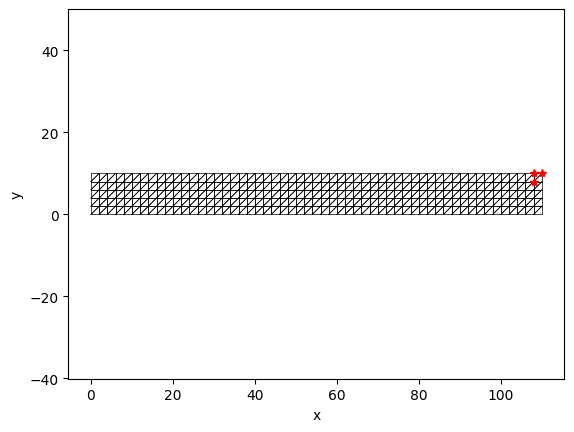

In [600]:
mu = 0.3
E = 2.1*10**11
h = 10
p = 55
m = 5
delta = 0.5
l = 11*h
element_type = 'D2TR3N'
NL, EL = uniform_function(h,p,m,delta,l)
paint(NL,EL)
EL = EL - np.ones((EL.shape[0],EL.shape[1]))
EL = EL.astype(int)
q = 100*10**6
eff = np.zeros((len(NL),2))
for i in range(len(NL)):
    if NL[i,0] >= l:
        if NL[i,1] >= h or NL[i,1] == 0:
            eff[i,0] = -h*q/m/2   
        else: 
            eff[i,0] = -h*q/m
#D = E/(1 - mu*mu)*np.array([[1,mu,0],[mu,1,0],[0,0, (1-mu)/2]])
D = E*(1-mu)/((1+mu)*(1-2*mu))*np.array([[1,mu/(1-mu),0],[mu/(1-mu),1,0],[0,0,(1-2*mu)/(2*(1-mu))]])
U = FEM(EL,NL,D,eff,len(NL),len(EL),l)

# Функции для построения локальной сетки (боковые)

In [601]:
def sidl(x0,y0,w,n):
  #сначала зададим узлы пока для 8
  nl=np.zeros([19,2])
  nl[0,0] = x0
  nl[0,1] = y0
  nl[1,0] = x0
  nl[1,1] = y0+w
  for i in range(3):
    nl[2+i,0]=x0+w/3
    nl[2+i,1]=y0+i*w/2
  for i in range(5):
    nl[5+i,0]=x0+2*w/3
    nl[5+i,1]=y0+i*w/4
  for i in range(9):
    nl[10+i,0]=x0+w
    nl[10+i,1]=y0+i*w/8
  #по узлам зададим элементы
  el = np.zeros([21,3])
  el[0,:]=[0,2,3]
  el[1,:]=[0,3,1]
  el[2,:]=[1,3,4]
  el[3,:]=[2,5,6]
  el[4,:]=[2,6,3]
  el[5,:]=[3,6,7]
  el[6,:]=[3,7,8]
  el[7,:]=[3,8,4]
  el[8,:]=[4,8,9]
  el[9,:]=[5,10,11]
  el[10,:]=[6,5,11]
  el[11,:]=[6,11,12]
  el[12,:]=[6,12,13]
  el[13,:]=[6,13,7]
  el[14,:]=[7,13,14]
  el[15,:]=[7,14,15]
  el[16,:]=[7,15,8]
  el[17,:]=[8,15,16]
  el[18,:]=[8,16,17]
  el[19,:]=[8,17,9]
  el[20,:]=[9,17,18]
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  
 
  return nl,el

In [602]:
def sidl1(x0,y0,w,n):
  #сначала зададим узлы пока для 16
  nl=np.zeros([27,2])
  nl[0,0] = x0
  nl[0,1] = y0
  nl[1,0] = x0
  nl[1,1] = y0+w
  for i in range(3):
    nl[2+i,0]=x0+w/3
    nl[2+i,1]=y0+i*w/2
  for i in range(5):
    nl[5+i,0]=x0+2*w/3
    nl[5+i,1]=y0+i*w/4
  for i in range(17):
    nl[10+i,0]=x0+w
    nl[10+i,1]=y0+i*w/16
  #по узлам зададим элементы
  el = np.zeros([29,3])
  el[0,:]=[0,2,3]
  el[1,:]=[0,3,1]
  el[2,:]=[1,3,4]
  el[3,:]=[2,5,6]
  el[4,:]=[2,6,3]
  el[5,:]=[3,6,7]
  el[6,:]=[3,7,8]
  el[7,:]=[3,8,4]
  el[8,:]=[4,8,9]
  el[9,:]=[5,10,11]
  el[10,:]=[6,12,5]
  el[11,:]=[5,12,11]
  el[12,:]=[6,13,12]
  el[13,:]=[6,14,13]
  el[14,:]=[6,14,15]
  el[15,:]=[6,15,16]
  el[16,:]=[6,16,7]
  el[17,:]=[7,16,17]
  el[18,:]=[7,17,18]
  el[19,:]=[7,18,19]
  el[20,:]=[7,19,20]
  el[21,:]=[7,20,8]
  el[22,:]=[8,20,21]
  el[23,:]=[8,21,22]
  el[24,:]=[8,22,23]
  el[25,:]=[8,23,24]
  el[26,:]=[8,24,9]
  el[27,:]=[9,24,25]
  el[28,:]=[9,25,26]
  
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  
 
  return nl,el

In [603]:
def sidr(x0,y0,w,n):
  #сначала зададим узлы пока для 8
  nl=np.zeros([19,2])
  nl[0,0] = x0+w
  nl[0,1] = y0
  nl[1,0] = x0+w
  nl[1,1] = y0+w
  for i in range(3):
    nl[2+i,0]=x0+2*w/3
    nl[2+i,1]=y0+i*w/2
  for i in range(5):
    nl[5+i,0]=x0+w/3
    nl[5+i,1]=y0+i*w/4
  for i in range(9):
    nl[10+i,0]=x0
    nl[10+i,1]=y0+i*w/8
  #по узлам зададим элементы
  el = np.zeros([21,3])
  el[0,:]=[0,3,2]
  el[1,:]=[0,1,3]
  el[2,:]=[1,4,3]
  el[3,:]=[2,6,5]
  el[4,:]=[2,3,6]
  el[5,:]=[3,7,6]
  el[6,:]=[3,8,7]
  el[7,:]=[3,4,8]
  el[8,:]=[4,9,8]
  el[9,:]=[5,11,10]
  el[10,:]=[5,6,11]
  el[11,:]=[6,12,11]
  el[12,:]=[6,13,12]
  el[13,:]=[6,7,13]
  el[14,:]=[7,14,13]
  el[15,:]=[7,15,14]
  el[16,:]=[7,8,15]
  el[17,:]=[8,16,15]
  el[18,:]=[8,17,16]
  el[19,:]=[8,9,17]
  el[20,:]=[9,18,17]
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  

  return nl,el

In [604]:
def sidr1(x0,y0,w,n):
  #сначала зададим узлы пока для 16
  nl=np.zeros([27,2])
  nl[0,0] = x0+w
  nl[0,1] = y0
  nl[1,0] = x0+w
  nl[1,1] = y0+w
  for i in range(3):
    nl[2+i,0]=x0+2*w/3
    nl[2+i,1]=y0+i*w/2
  for i in range(5):
    nl[5+i,0]=x0+w/3
    nl[5+i,1]=y0+i*w/4
  for i in range(17):
    nl[10+i,0]=x0
    nl[10+i,1]=y0+i*w/16
  #по узлам зададим элементы
  el = np.zeros([29,3])
  el[0,:]=[0,2,3]
  el[1,:]=[0,3,1]
  el[2,:]=[1,3,4]
  el[3,:]=[2,5,6]
  el[4,:]=[2,6,3]
  el[5,:]=[3,6,7]
  el[6,:]=[3,7,8]
  el[7,:]=[3,8,4]
  el[8,:]=[4,8,9]
  el[9,:]=[5,10,11]
  el[10,:]=[6,12,5]
  el[11,:]=[5,12,11]
  el[12,:]=[6,13,12]
  el[13,:]=[6,14,13]
  el[14,:]=[6,14,15]
  el[15,:]=[6,15,16]
  el[16,:]=[6,16,7]
  el[17,:]=[7,16,17]
  el[18,:]=[7,17,18]
  el[19,:]=[7,18,19]
  el[20,:]=[7,19,20]
  el[21,:]=[7,20,8]
  el[22,:]=[8,20,21]
  el[23,:]=[8,21,22]
  el[24,:]=[8,22,23]
  el[25,:]=[8,23,24]
  el[26,:]=[8,24,9]
  el[27,:]=[9,24,25]
  el[28,:]=[9,25,26]
  
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  
 
  return nl,el

In [605]:
def sidd(x0,y0,w,n):
  #сначала зададим узлы пока для 8
  nl=np.zeros([19,2])
  nl[0,0] = x0
  nl[0,1] = y0
  nl[1,0] = x0+w
  nl[1,1] = y0
  for i in range(3):
    nl[2+i,0]=x0+i*w/2
    nl[2+i,1]=y0+w/3
  for i in range(5):
    nl[5+i,0]=x0+i*w/4
    nl[5+i,1]=y0+2*w/3
  for i in range(9):
    nl[10+i,0]=x0+i*w/8
    nl[10+i,1]=y0+w
  #по узлам зададим элементы
  el = np.zeros([21,3])
  el[0,:]=[0,3,2]
  el[1,:]=[0,1,3]
  el[2,:]=[1,4,3]
  el[3,:]=[2,6,5]
  el[4,:]=[2,3,6]
  el[5,:]=[3,7,6]
  el[6,:]=[3,8,7]
  el[7,:]=[3,4,8]
  el[8,:]=[4,9,8]
  el[9,:]=[5,11,10]
  el[10,:]=[5,6,11]
  el[11,:]=[6,12,11]
  el[12,:]=[6,13,12]
  el[13,:]=[6,7,13]
  el[14,:]=[7,14,13]
  el[15,:]=[7,15,14]
  el[16,:]=[7,8,15]
  el[17,:]=[8,16,15]
  el[18,:]=[8,17,16]
  el[19,:]=[8,9,17]
  el[20,:]=[9,18,17]
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  
  return nl,el

In [606]:

def conl(x0,y0,w):
  nl=np.zeros([11,2])
  nl[0,0] = x0
  nl[0,1] = y0
  nl[1,0] = x0+w
  nl[1,1] = y0
  nl[2,0] = x0+w/2
  nl[2,1] = y0+w/2
  nl[3,0] = x0
  nl[3,1] = y0+w
  nl[4,0] = x0+w/3
  nl[4,1] = y0+w
  nl[5,0] = x0+2*w/3
  nl[5,1] = y0+2*w/3
  nl[6,0] = x0+w
  nl[6,1] = y0+w/3
  nl[7,0] = x0+w
  nl[7,1] = y0+w*2/3
  nl[8,0] = x0+5*w/6
  nl[8,1] = y0+5*w/6
  nl[9,0] = x0+2*w/3
  nl[9,1] = y0+w
  nl[10,0] = x0+w
  nl[10,1] = y0+w
  el = np.zeros([12,3])
  el[0,:]=[0,1,2]
  el[1,:]=[0,2,3]
  el[2,:]=[3,2,4]
  el[3,:]=[4,2,5]
  el[4,:]=[2,1,5]
  el[5,:]=[5,1,6]
  el[6,:]=[6,7,8]
  el[7,:]=[5,6,8]
  el[8,:]=[5,8,9]
  el[9,:]=[5,9,4]
  el[10,:]=[9,8,10]
  el[11,:]=[8,7,10]
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  
  return nl,el


In [607]:
def conr(x0,y0,w):
  nl=np.zeros([11,2])
  nl[0,0] = x0+w
  nl[0,1] = y0
  nl[1,0] = x0
  nl[1,1] = y0
  nl[2,0] = x0+w/2
  nl[2,1] = y0+w/2
  nl[3,0] = x0+w
  nl[3,1] = y0+w
  nl[4,0] = x0+2*w/3
  nl[4,1] = y0+w
  nl[5,0] = x0+w/3
  nl[5,1] = y0+2*w/3
  nl[6,0] = x0
  nl[6,1] = y0+w/3
  nl[7,0] = x0
  nl[7,1] = y0+w*2/3
  nl[8,0] = x0+w/6
  nl[8,1] = y0+5*w/6
  nl[9,0] = x0+w/3
  nl[9,1] = y0+w
  nl[10,0] = x0
  nl[10,1] = y0+w
  el = np.zeros([12,3])
  el[0,:]=[0,2,1]
  el[1,:]=[0,3,2]
  el[2,:]=[3,4,2]
  el[3,:]=[4,5,2]
  el[4,:]=[2,5,1]
  el[5,:]=[5,6,1]
  el[6,:]=[6,8,7]
  el[7,:]=[5,8,6]
  el[8,:]=[5,9,8]
  el[9,:]=[5,4,9]
  el[10,:]=[9,10,8]
  el[11,:]=[7,8,10]
  el = el + np.ones((el.shape[0],el.shape[1]))
  el = el.astype(int)
  
  return nl,el

 # Функции для построения локальной сетки (центральные)

Сетка для прямоугольника

In [608]:
def uniform_function_(x0,y0,d1,d2,p,m):
    PD = 2
    q = np.array([[x0,y0],[x0+d1,y0],[x0,y0+d2],[x0+d1,y0+d2]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, PD])
    a = (q[1,0]-q[0,0])/p
    b = (q[2,1]-q[0,1])/m
    n = 0
    for i in range(1,m+2):
        for j in range(1,p+2):
            NL[n,0] = q[0,0]+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]
            
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
        
    EL = EL.astype(int)
    NPEn = 3
    count2 = 1
    #for j in range(0,NoE*2):
     #   plt.annotate(count2,xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3,(NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3),c = 'blue')
      #  count2 += 1
    return NL, EL

сетка с правым краем по окружности 

In [609]:
def half_circle1(x0,y0,delta,w,p,m):
    q = np.array([[x0,y0],[x0+w,y0],[x0+w-delta,y0+delta],[x0+w,y0+delta]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, 2])
    b = delta/m
    n = 0
    for i in range(1,m+2):
        a = ( w - ma.sqrt(delta**2-((m+1-i)*b)**2))/p 
        for j in range(1,p+2):
            NL[n,0] = q[0,0]+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]   
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
        
    EL = EL.astype(int)
    NPEn = 3
    count2 = 1
   # for j in range(0,NoE*2):
    #    plt.annotate(count2,xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3,(NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3),c = 'blue')
     #   count2 += 1
    return NL, EL

сетка с левым краем по окружности

In [610]:
def half_circle2(x0,y0,delta,w,p,m):
    q = np.array([[x0,y0],[x0+w,y0],[x0,y0+delta],[x0+w,y0+delta]])
    NoN = (p+1)*(m+1)
    NoE = p*m
    NPE = 4
    NL = np.zeros([NoN, 2])
    b = delta/m
    n = 0
    
    for i in range(1,m+2):
        a = (w-ma.sqrt(delta**2-((m+1-i)*b)**2))/p 
        st = ma.sqrt(delta**2-((m+1-i)*b)**2)
        for j in range(1,p+2):
            NL[n,0] = x0+st+(j-1)*a
            NL[n,1] = q[0,1]+(i-1)*b
            n+=1
    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,p+1):
            if j == 1:
                
                EL[(i-1)*p+j-1,0] = ((i-1)*(p+1) + j)
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-1,0] + (p+1))
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] +1)
            else:
                EL[(i-1)*p+j-1,0] = (EL[(i-1)*p+j-2,1])
                EL[(i-1)*p+j-1,3] = (EL[(i-1)*p+j-2,2])
                EL[(i-1)*p+j-1,1] = (EL[(i-1)*p+j-1,0] + 1)
                EL[(i-1)*p+j-1,2] = (EL[(i-1)*p+j-1,3] + 1)
    
    NPEn = 3
    NoEn = NoE*2
    ELn = np.zeros([NoEn,NPEn])
    for i in range(1,NoE+1):
        ELn[2*(i-1),0] = EL[i-1,0]
        ELn[2*(i-1),1] = EL[i-1,1]
        ELn[2*(i-1),2] = EL[i-1,2]   
        ELn[2*(i-1)+1,0] = EL[i-1,0]
        ELn[2*(i-1)+1,1] = EL[i-1,2]
        ELn[2*(i-1)+1,2] = EL[i-1,3]
    EL = ELn
        
    EL = EL.astype(int)
    NPEn = 3
    count2 = 1
   # for j in range(0,NoE*2):
    #    plt.annotate(count2,xy = ((NL[EL[j,0]-1,0]+NL[EL[j,1]-1,0]+NL[EL[j,2]-1,0])/3,(NL[EL[j,0]-1,1]+NL[EL[j,1]-1,1]+NL[EL[j,2]-1,1])/3),c = 'blue')
     #   count2 += 1
    return NL, EL

Функция объединения сеток

In [611]:
def uni(nla,ela,nlb,elb):
  
  ss = []
  ss1 = []
  for i in range(len(nla)):
    for j in range(len(nlb)):
      if abs(nla[i,0]-nlb[j,0])<delta/1000 and abs(nla[i,1]-nlb[j,1])<delta/1000:
        ss.append(i+1)
        ss1.append(j+1) 
        
     
  ss2 = list(np.array(ss1)-1)
  sortss1 = sorted(ss1)
  nlb = np.delete(nlb,ss2,axis=0)
  for i in range(len(elb)):
    
    for j in range(3):
      if elb[i,j] in ss1:
        
        for k in range(len(ss1)):
          if elb[i,j] == ss1[k]:
            elb[i,j] = ss[k]
      elif elb[i,j] > max(ss1):
        elb[i,j] += len(nla) - len(ss)
      elif elb[i,j] < min(ss1):
        elb[i,j] += len(nla)
      else: 
        for k in range(len(sortss1)):
          if elb[i,j] < sortss1[k]:
            elb[i,j]+=len(nla)-k
      
            break
    
  elans = np.vstack([ela,elb])            
  nlans = np.vstack([nla,nlb])
  
  
  return nlans,elans

Код для окончания дефекта (только полукруг, глубина не учитывается)

In [612]:
def local_mesh_without_deep(r,lef,top,w):
    p=4
    m=3
    
    #бока
    nl11,el11=sidl(lef-w,top-w,w,8)
    nl12,el12=sidl(lef-w,top-2*w,w,8)
    nl13,el13=sidl(lef-w,top-3*w,w,8)
    nl14,el14=sidl(lef-w,top-4*w,w,8)
    nl15,el15=conl(lef-w,top-5*w,w)
    nl21,el21=sidr(lef+w,top-w,w,8)
    nl22,el22=sidr(lef+w,top-2*w,w,8)
    nl23,el23=sidr(lef+w,top-3*w,w,8)
    nl24,el24=sidr(lef+w,top-4*w,w,8)
    nl25,el25=conr(lef+w,top-5*w,w)

    
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-r,r,w/2,p,2)
    #def half_circle1(x0,y0,delta,h,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-r,r,w/2,p,2)
    #paint(NLII1,ELII1)
    #paint(NLII,ELII)
    # область III заполняется как прямоугольник
    
    NLa,ELa = uniform_function_(lef,top-2,w,w-r,p*2,m*2)
    NLb,ELb = uniform_function_(lef,top-4,w,w,p*2,8)
    NLc,ELc = uniform_function_(lef,top-6,w,w,p*2,8)
    NLe,ELe = uniform_function_(lef,top-8,w,w,p*2,8)
    NLf,ELf=sidd(lef,top-5*w,w,8)
    
    #левая часть
    NLl,ELl = uni(nl15,el15,nl14,el14)
    NLl,ELl = uni(NLl,ELl,nl13,el13)
    NLl,ELl = uni(NLl,ELl,nl12,el12)
    NLl,ELl = uni(NLl,ELl,nl11,el11)
    print(len(ELl),len(el11)+len(el12)+len(el13)+len(el14)+len(el15))
   
    #правая часть
    NLr,ELr = uni(nl21,el21,nl22,el22)
    NLr,ELr = uni(NLr,ELr,nl23,el23)
    NLr,ELr = uni(NLr,ELr,nl24,el24)
    NLr,ELr = uni(NLr,ELr,nl25,el25)
   
    #центр
    NLm,ELm = uni(NLII,ELII,NLII1,ELII1)
    NLm,ELm = uni(NLm,ELm,NLa,ELa)
    NLm,ELm = uni(NLm,ELm,NLb,ELb)
    NLm,ELm = uni(NLm,ELm,NLc,ELc)
    NLm,ELm = uni(NLm,ELm,NLe,ELe)
    NLm,ELm = uni(NLm,ELm,NLf,ELf)
    
    
    NL_,EL_ = uni(NLr,ELr,NLm,ELm)
    NL_,EL_ = uni(NL_,EL_,NLl,ELl)
    print(len(EL_),len(ELm)+len(ELr)+len(ELl))
    paint(NL_,EL_)
    return NL_,EL_

In [613]:
def local_mesh1(r,lef,top,w):
    p=4
    m=3
    
    #бока
    nl11,el11=sidl(lef-w,top-w,w,8)
    nl12,el12=sidl(lef-w,top-2*w,w,8)
    
    nl15,el15=conl(lef-w,top-3*w,w)
    nl21,el21=sidr(lef+w,top-w,w,8)
    nl22,el22=sidr(lef+w,top-2*w,w,8)
    
    nl25,el25=conr(lef+w,top-3*w,w)

    
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-r,r,w/2,p,2)
    #def half_circle1(x0,y0,delta,h,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-r,r,w/2,p,2)
    #paint(NLII1,ELII1)
    #paint(NLII,ELII)
    # область III заполняется как прямоугольник
    
    NLa,ELa = uniform_function_(lef,top-2,w,w-r,p*2,m*2)
    NLb,ELb = uniform_function_(lef,top-4,w,w,p*2,8)
    
    NLf,ELf=sidd(lef,top-3*w,w,8)
    
    #левая часть
    NLl,ELl = uni(nl15,el15,nl12,el12)
    
    NLl,ELl = uni(NLl,ELl,nl11,el11)
    print(len(ELl),len(el11)+len(el12)+len(el15))
   
    #правая часть
    NLr,ELr = uni(nl21,el21,nl22,el22)
    
    NLr,ELr = uni(NLr,ELr,nl25,el25)
   
    #центр
    NLm,ELm = uni(NLII,ELII,NLII1,ELII1)
    NLm,ELm = uni(NLm,ELm,NLa,ELa)
    NLm,ELm = uni(NLm,ELm,NLb,ELb)
    
    NLm,ELm = uni(NLm,ELm,NLf,ELf)
    
    
    NL_,EL_ = uni(NLr,ELr,NLm,ELm)
    NL_,EL_ = uni(NL_,EL_,NLl,ELl)
    print(len(EL_),len(ELm)+len(ELr)+len(ELl))
    paint(NL_,EL_)
    return NL_,EL_

In [614]:
def local_mesh2(r,lef,top,w):
    p=4
    m=3
    
    #бока
    nl11,el11=sidl(lef-w,top-w,w,8)
    nl15,el15=conl(lef-w,top-2*w,w)
    nl21,el21=sidr(lef+w,top-w,w,8)
    nl25,el25=conr(lef+w,top-2*w,w)

    
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-r,r,w/2,p,2)
    #def half_circle1(x0,y0,delta,h,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-r,r,w/2,p,2)
    #paint(NLII1,ELII1)
    #paint(NLII,ELII)
    # область III заполняется как прямоугольник
    
    NLa,ELa = uniform_function_(lef,top-2,w,w-r,p*2,m*2)
       
    NLf,ELf=sidd(lef,top-2*w,w,8)
    
    #левая часть
    NLl,ELl = uni(nl15,el15,nl11,el11)
    
    print(len(ELl),len(el11)+len(el15))
   
    #правая часть
    NLr,ELr = uni(nl21,el21,nl25,el25)
    
    #центр
    NLm,ELm = uni(NLII,ELII,NLII1,ELII1)
    NLm,ELm = uni(NLm,ELm,NLa,ELa)
  
    
    NLm,ELm = uni(NLm,ELm,NLf,ELf)
    
    
    NL_,EL_ = uni(NLr,ELr,NLm,ELm)
    NL_,EL_ = uni(NL_,EL_,NLl,ELl)
    print(len(EL_),len(ELm)+len(ELr)+len(ELl))
    paint(NL_,EL_)
    return NL_,EL_

In [615]:
def local_mesh21(r,lef,top,w):
    p=4
    m=3
    
    #бока
    nl11,el11=sidl1(lef-w,top-w,w,8)
    nl15,el15=conl(lef-w,top-2*w,w)
    nl21,el21=sidr1(lef+w,top-w,w,8)
    nl25,el25=conr(lef+w,top-2*w,w)

    
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-r,r,w/2,p,4)
    #def half_circle1(x0,y0,delta,h,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-r,r,w/2,p,4)
    #paint(NLII1,ELII1)
    #paint(NLII,ELII)
    # область III заполняется как прямоугольник
    
    NLa,ELa = uniform_function_(lef,top-2,w,w-r,p*2,m*4)
       
    NLf,ELf=sidd(lef,top-2*w,w,8)
    
    #левая часть
    NLl,ELl = uni(nl15,el15,nl11,el11)
    
    print(len(ELl),len(el11)+len(el15))
   
    #правая часть
    NLr,ELr = uni(nl21,el21,nl25,el25)
    
    #центр
    NLm,ELm = uni(NLII,ELII,NLII1,ELII1)
    NLm,ELm = uni(NLm,ELm,NLa,ELa)
  
    
    NLm,ELm = uni(NLm,ELm,NLf,ELf)
    
    
    NL_,EL_ = uni(NLr,ELr,NLm,ELm)
    NL_,EL_ = uni(NL_,EL_,NLl,ELl)
    print(len(EL_),len(ELm)+len(ELr)+len(ELl))
    paint(NL_,EL_)
    return NL_,EL_

In [616]:
def local_mesh3(r,lef,top,w):
    p=4
    m=3
    
    
    # область II и симметричная ей II'
    NLII,ELII = half_circle1(lef,top-r,r,w/2,p,4)
    #def half_circle1(x0,y0,delta,h,p,m)
    NLII1,ELII1 = half_circle2(lef+w/2,top-r,r,w/2,p,4)
    #paint(NLII1,ELII1)
    #paint(NLII,ELII)
    # область III заполняется как прямоугольник
    
    NLa,ELa = uniform_function_(lef,top-2,w,w-r,p*2,m*4)
       
   
    
    #центр
    NLm,ELm = uni(NLII,ELII,NLII1,ELII1)
    NL_,EL_ = uni(NLm,ELm,NLa,ELa)
  
  
    paint(NL_,EL_)
    return NL_,EL_

#Подробное описание функций выше



1. uniform_function_(x0,y0,d1,d2,p,m)
Задаёт сетку для прямоугольника.
*   x0 - координата по горизонтали левой нижней точки прямоугольника 
*   y0 - координата по вертикали левой нижней точки прямоугольника 
*  d1 - ширина прямоугольника 
* d2 - высота прямоугольника
* p - количество элементов по горизонтали 
* m - количество элементов по вертикали 
2. half_circle1(x0,y0,r,w,p,m)
Задаёт сетку на четырёхугольнике, где правая сторона - четверть дуги
* x0 - координата по горизонтали левой нижней точки
* y0 - координата по вертикали левой нижней точки
* w - максимальная ширина четырёхугольника
* r - радиус дуги
* p - количество элементов по горизонтали 
* m - количество элементов по вертикали 
3. half_circle2(x0,y0,delta,w,p,m)
Задаёт сетку на четырёхугольнике, где левая сторона - четверть дуги
* x0 - координата по горизонтали левой нижней точки
* y0 - координата по вертикали левой нижней точки
* w - максимальная ширина четырёхугольника
* r - радиус дуги
* p - количество элементов по горизонтали 
* m - количество элементов по вертикали
4. local_mesh_without_deep(r,lef,top,w)
Разбивает !квадрат! на локальную сетку, если у дефекта ещё нет глубины
* r - радиус дефекта
* lef - координата левой границы квадрата
* top - верхняя граница квадрата
* w - длина стороны квадрата
5. local_mesh(r,lef,w,top,deep)
Разбивает !квадрат! на локальную сетку
* r - радиус дефекта
* lef - координата левой границы квадрата
* top - верхняя граница квадрата
* w - длина стороны квадрата
* deep - глубина деекта без учёта радиуса



# Новая(правильная) локальная сетка

In [617]:
def paint(cord,elem):
    x0, y0 = cord[elem[:,0]-1,0], cord[elem[:,0]-1,1]
    x1, y1 = cord[elem[:,1]-1,0], cord[elem[:,1]-1,1]
    x2, y2 = cord[elem[:,2]-1,0], cord[elem[:,2]-1,1]
    plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
    plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
    plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
    plt.axis('equal')
    #for i in range(len(cord)):
     # plt.annotate(i+1,xy = (cord[i,0]+0.02,cord[i,1]),c="red")
    #count2=1
    #for j in range(0,len(elem)):
     #   plt.annotate(count2,xy = ((cord[elem[j,0]-1,0]+cord[elem[j,1]-1,0]+cord[elem[j,2]-1,0])/3,(cord[elem[j,0]-1,1]+cord[elem[j,1]-1,1]+cord[elem[j,2]-1,1])/3),c = 'blue')
      #  count2 += 1
    
    #plt.grid()
    return 

# сетка во всю высоту

96 96
725 725


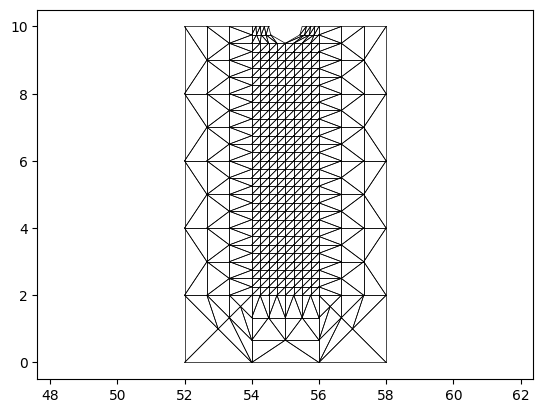

In [638]:
#начальная глубина равна 0
deep = 0
#считаем, на сколько квадратов надо уйти в глубину
sqcount = ma.ceil(deep)
#обозначаем боковые границы элементов, которых касается дефект
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
#проверим есть ли такие узлы в глобальной сетке
#for c in NL:
 # if c[0]==left_b:
  #  print('its left ',c)
  #elif c[0]==right_b:
   # print('its right ',c)

if deep == 0: 
  NLgl,ELgl = local_mesh_without_deep(delta,left_b,h,h/5)
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)

In [639]:


ln = len(NLgl)
le = len(ELgl)
left_b=left_b-h/5
right_b=right_b+h/5
Ugl = np.zeros((ln*2,1))
for i in range(len(NL)):
    if abs(left_b-NL[i,0])<h/1000 or abs(right_b-NL[i,0])<h/1000 :
        for j in range(ln):
          if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
              #print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1])
              #print(U[i*2],U[i*2+1])
              Ugl[j*2] = U[i*2]
              Ugl[j*2+1] = U[i*2+1]
    


In [640]:
K0 = np.zeros((ln*2,ln*2))
for i in range(0,le):
    ind = ELgl[i,:]
    K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)

In [641]:
rig = np.zeros((1,ln*2))
#нулевой вектор правой части
rig1 = -K0.dot(Ugl)
#вектор правой части после умножения на вектор известных премещений
for i in range(2*ln): #учёт не нулей
    if abs(Ugl[i])>0:
        K0[i,:] = K0[i,:]*0
        K0[:,i] = K0[:,i]*0
        K0[i,i] = 1
        rig1[i]=0
Ufin = np.linalg.solve(K0,rig1)

#print(len(Ugl),len(Ufin))
#for i in range(len(Ufin)):
  #print(Ugl[i],Ufin[i])
  #if abs(Ugl[i])>0:
    #Ufin[i]=Ugl[i]
    #print(1,Ugl[i],Ufin[i])
Ufin = Ufin+Ugl

#сетка на три квадрата

54 54
385 385


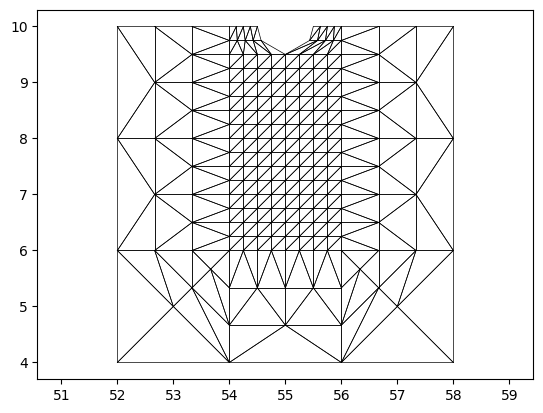

In [581]:
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
NLgl,ELgl = local_mesh1(delta,left_b,h,h/5)
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
ln = len(NLgl)
le = len(ELgl)
left_b=left_b-h/5
right_b=right_b+h/5
Ugl = np.zeros((ln*2,1))
for i in range(len(NL)):
    if abs(left_b-NL[i,0])<h/1000 or abs(right_b-NL[i,0])<h/1000 or abs(4-NL[i,1])<h/1000:
        for j in range(ln):
          if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
              #print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1])
              #print(U[i*2],U[i*2+1])
              Ugl[j*2] = U[i*2]
              Ugl[j*2+1] = U[i*2+1]
K0 = np.zeros((ln*2,ln*2))
for i in range(0,le):
    ind = ELgl[i,:]
    K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)
rig = np.zeros((1,ln*2))
#нулевой вектор правой части
rig1 = -K0.dot(Ugl)
#вектор правой части после умножения на вектор известных премещений
for i in range(2*ln): #учёт не нулей
    if abs(Ugl[i])>0:
        K0[i,:] = K0[i,:]*0
        K0[:,i] = K0[:,i]*0
        K0[i,i] = 1
        rig1[i]=0
Ufin = np.linalg.solve(K0,rig1)

#print(len(Ugl),len(Ufin))
#for i in range(len(Ufin)):
  #print(Ugl[i],Ufin[i])
  #if abs(Ugl[i])>0:
    #Ufin[i]=Ugl[i]
    #print(1,Ugl[i],Ufin[i])
Ufin = Ufin+Ugl

# сетка в два квадрата

33 33
215 215


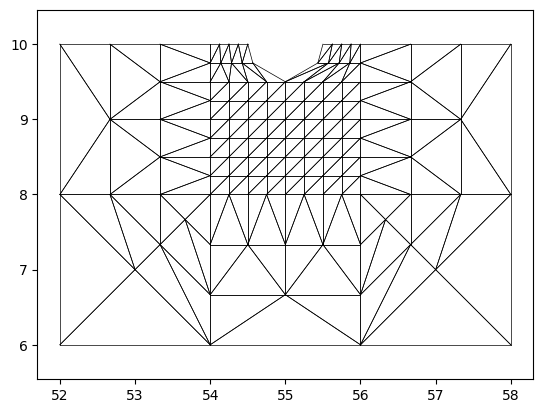

In [576]:
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
NLgl,ELgl = local_mesh2(delta,left_b,h,h/5)
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
ln = len(NLgl)
le = len(ELgl)
left_b=left_b-h/5
right_b=right_b+h/5
Ugl = np.zeros((ln*2,1))
for i in range(len(NL)):
    if abs(left_b-NL[i,0])<h/1000 or abs(right_b-NL[i,0])<h/1000 or abs(6-NL[i,1])<h/1000:
        for j in range(ln):
          if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
              print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1])
              #print(U[i*2],U[i*2+1])
              Ugl[j*2] = U[i*2]
              Ugl[j*2+1] = U[i*2+1]
K0 = np.zeros((ln*2,ln*2))
for i in range(0,le):
    ind = ELgl[i,:]
    K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)
rig = np.zeros((1,ln*2))
#нулевой вектор правой части
rig1 = -K0.dot(Ugl)
#вектор правой части после умножения на вектор известных премещений
for i in range(2*ln): #учёт не нулей
    if abs(Ugl[i])>0:
        K0[i,:] = K0[i,:]*0
        K0[:,i] = K0[:,i]*0
        K0[i,i] = 1
        rig1[i]=0
Ufin = np.linalg.solve(K0,rig1)

#print(len(Ugl),len(Ufin))
#for i in range(len(Ufin)):
  #print(Ugl[i],Ufin[i])
  #if abs(Ugl[i])>0:
    #Ufin[i]=Ugl[i]
    #print(1,Ugl[i],Ufin[i])
Ufin = Ufin+Ugl

# частая сетка в два квадрата

41 41
359 359


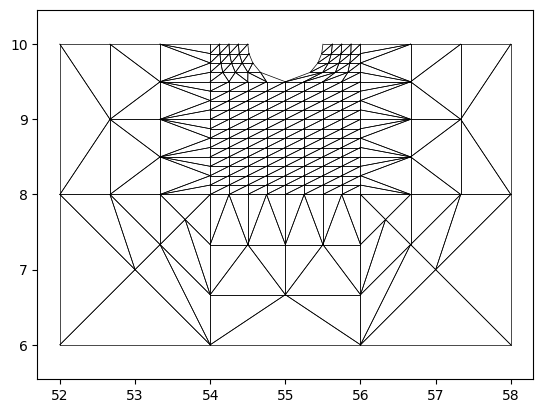

In [451]:
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
NLgl,ELgl = local_mesh21(delta,left_b,h,h/5)
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
ln = len(NLgl)
le = len(ELgl)
left_b=left_b-h/5
right_b=right_b+h/5
Ugl = np.zeros((ln*2,1))
for i in range(len(NL)):
    if abs(left_b-NL[i,0])<h/1000 or abs(right_b-NL[i,0])<h/1000 or abs(6-NL[i,1])<h/1000:
        for j in range(ln):
          if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
              #print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1])
              #print(U[i*2],U[i*2+1])
              Ugl[j*2] = U[i*2]
              Ugl[j*2+1] = U[i*2+1]
K0 = np.zeros((ln*2,ln*2))
for i in range(0,le):
    ind = ELgl[i,:]
    K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)
rig = np.zeros((1,ln*2))
#нулевой вектор правой части
rig1 = -K0.dot(Ugl)
#вектор правой части после умножения на вектор известных премещений
for i in range(2*ln): #учёт не нулей
    if abs(Ugl[i])>0:
        K0[i,:] = K0[i,:]*0
        K0[:,i] = K0[:,i]*0
        K0[i,i] = 1
        rig1[i]=0
Ufin = np.linalg.solve(K0,rig1)

#print(len(Ugl),len(Ufin))
#for i in range(len(Ufin)):
  #print(Ugl[i],Ufin[i])
  #if abs(Ugl[i])>0:
    #Ufin[i]=Ugl[i]
    #print(1,Ugl[i],Ufin[i])
Ufin = Ufin+Ugl

# аппроксимация частая 1 квадрат

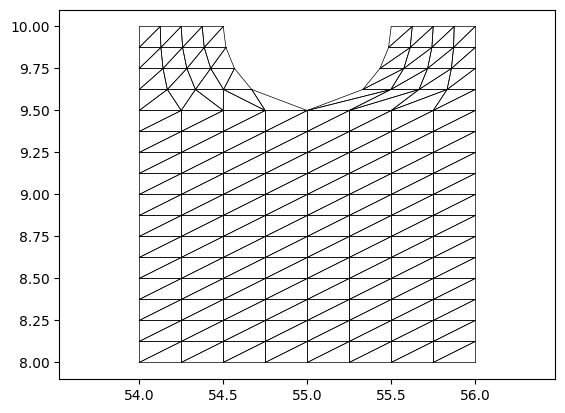

In [448]:
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
NLgl,ELgl = local_mesh3(delta,left_b,h,h/5)
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
ln = len(NLgl)
le = len(ELgl)

Ugl = np.zeros((ln*2,1))
ea = NL[251,:]
eb = NL[252,:]
ec = NL[307,:]
ed = NL[308,:]
count = 0
count1 = 0
for i in range(ln):
  if abs(8-NLgl[i,1])<h/1000:
    count+=1
for i in range(ln):
  if abs(8-NLgl[i,1])<h/1000:
    Ugl[i*2] = U[251*2]*count1/count + U[252*2]*(count-count1)/count
    Ugl[i*2+1] = U[251*2+1]*count1/count + U[252*2+1]*(count-count1)/count  
    count1+=1 
count = 0
count1=0
for i in range(ln):
  if abs(left_b-NLgl[i,0])<h/1000:
    count+=1
for i in range(ln):
  if abs(left_b-NLgl[i,0])<h/1000:
    Ugl[i*2] = U[251*2]*count1/count + U[307*2]*(count-count1)/count 
    Ugl[i*2+1] = U[251*2+1]*count1/count + U[307*2+1]*(count-count1)/count 
    count1+=1 
count1=0
count = 0
for i in range(ln):
  if abs(right_b-NLgl[i,0])<h/1000:
    count+=1
for i in range(ln):
  if abs(right_b-NLgl[i,0])<h/1000:
    Ugl[i*2] = U[252*2]*count1/count + U[308*2]*(count-count1)/count 
    Ugl[i*2+1] = U[252*2+1]*count1/count + U[308*2+1]*(count-count1)/count 
    count1+=1 


#for i in range(len(NL)):
 #   if abs(left_b-NL[i,0])<h/1000 or abs(right_b-NL[i,0])<h/1000 or abs(8-NL[i,1])<h/1000:
  #      for j in range(ln):
   #       if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
    #          print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1],i,j)
     #         print(U[i*2],U[i*2+1])
      #        Ugl[j*2] = U[i*2]
       #       Ugl[j*2+1] = U[i*2+1]
K0 = np.zeros((ln*2,ln*2))
for i in range(0,le):
    ind = ELgl[i,:]
    K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)
rig = np.zeros((1,ln*2))
#нулевой вектор правой части
rig1 = -K0.dot(Ugl)
#вектор правой части после умножения на вектор известных премещений
for i in range(2*ln): #учёт не нулей
    if abs(Ugl[i])>0:
        K0[i,:] = K0[i,:]*0
        K0[:,i] = K0[:,i]*0
        K0[i,i] = 1
        rig1[i]=0
Ufin = np.linalg.solve(K0,rig1)

#print(len(Ugl),len(Ufin))
#for i in range(len(Ufin)):
  #print(Ugl[i],Ufin[i])
  #if abs(Ugl[i])>0:
    #Ufin[i]=Ugl[i]
    #print(1,Ugl[i],Ufin[i])
Ufin = Ufin+Ugl

# пример

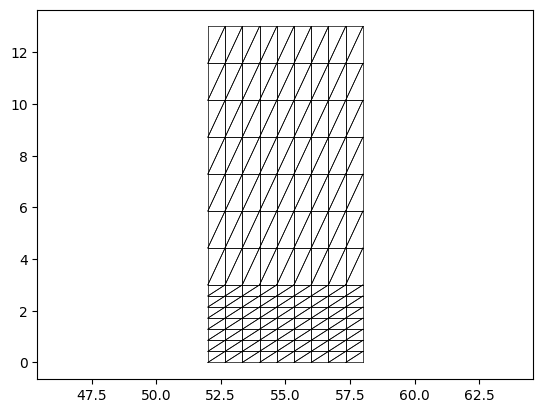

In [453]:
NL1,EL1 = uniform_function_(52,0,6,3,9,7)
NL2,EL2 = uniform_function_(52,3,6,10,9,7)
NLgl,ELgl = uni(NL1,EL1,NL2,EL2)
paint(NLgl,ELgl )
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)

96 96
725 725


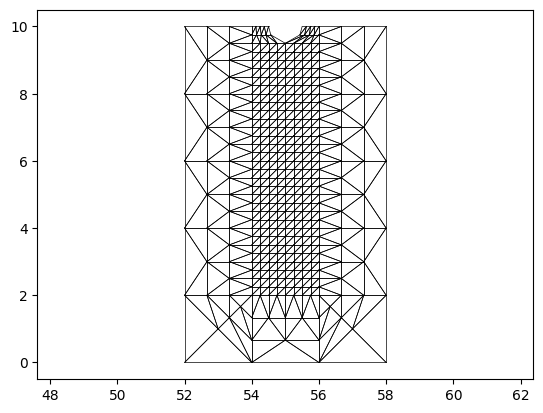

In [454]:
left_b = h*5+2*h/5
right_b = 5*h+3*h/5
NLgl,ELgl = local_mesh_without_deep(delta,left_b,h,h/5)
ELgl = ELgl - np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)

In [455]:
left_b=52
right_b=58

In [456]:
q=100
eff = np.zeros((len(NLgl),2))
for i in range(len(NLgl)):
    if  abs(NLgl[i,0]-right_b) <1/10000 :
        print(NLgl[i,0],right_b)
        if NLgl[i,1] >= h or NLgl[i,1] == 0:
            eff[i,0] = 10*q/5/2   
        else: 
            eff[i,0] = 10*q/5
rig = right(eff,len(NLgl))

K0 = np.zeros((len(NLgl)*2,len(NLgl)*2))
for i in range(0,len(ELgl)):
  ind = ELgl[i,:]
  K0 = sum_K(K0,make_K(i,ELgl,NLgl,D),ind,i)
for i in range(len(NLgl)):
      #закрепляем
  if abs(NLgl[i,0]-left_b)<1/(p*m*1000):
      K0[i*2,:] = K0[i,:]*0
      K0[:,2*i] = K0[:,i]*0
      K0[i*2,i*2] = 1  
      rig[i*2] = 0
  #if abs(NLgl[i,1])<1/(p*m*1000):
   #   K0[i*2+1,:] = K0[i,:]*0
    #  K0[:,2*i+1] = K0[:,i]*0
    #  K0[i*2+1,i*2+1] = 1    
Ufin = np.linalg.solve(K0,rig.T)

58.0 58
58.0 58
58.0 58
58.0 58
58.0 58
58.0 58


#...

30255483.0959026
28591790.91370284
9332272.953850178
24308178.804476224
29854126.5796035
28319463.992629718
sigmamax =  111617742.8405852
sigmamin =  0
[54.  0.] [56.  0.] [55.          0.66666667]
Количество элементов  725


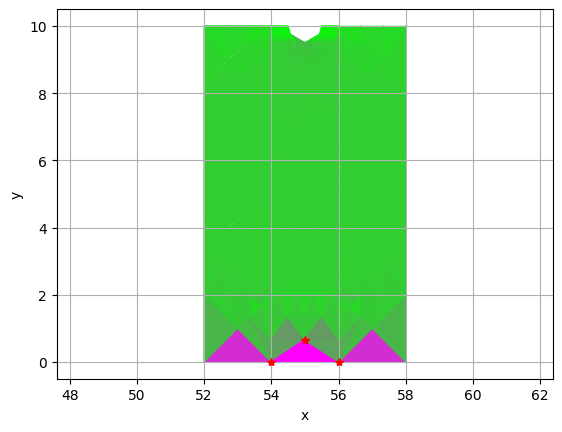

In [637]:
ln = len(NLgl)
le = len(ELgl)
lnap = np.matrix([-1,-1,-1])
max_sig = 0
min_sig = 0
max_sig_i = -1
m_s=0
m_s_i=-1
for i in range(le):
    B = make_B(i,ELgl,NLgl,D)
    Ui = np.zeros((6))
    Ui[0] = Ufin[ELgl[i,0]*2]
    Ui[1] = Ufin[ELgl[i,0]*2+1]
    Ui[2] = Ufin[ELgl[i,1]*2]
    Ui[3] = Ufin[ELgl[i,1]*2+1]  
    Ui[4] = Ufin[ELgl[i,2]*2]
    Ui[5] = Ufin[ELgl[i,2]*2+1]#деформации (эпсилон)    
    Eps = B.dot(Ui)    # напряжения(сигма)
    Nap = D.dot(Eps) 
    lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
    NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]]) 
    now_sig = abs(Nap[0])
    a = NLgl[ELgl[i,0],:]
    b = NLgl[ELgl[i,1],:]
    c = NLgl[ELgl[i,2],:]
    #print(now_sig)
    e = plt.Polygon([a,b,c],color=[(now_sig)/(111617744),1 - (now_sig)/(111617744),(now_sig)/(111617744)])
    #e = plt.Polygon([a,b,c],color=[abs(now_sig)/4500,1 - abs(now_sig)/4500,abs(now_sig)/4500])
    #e = plt.Polygon([a,b,c],color=[abs(now_sig)/101126640282,1 - abs(now_sig)/101166024282,abs(now_sig)/106610124282])
    plt.gca().add_patch(e)
    #Sig,s = np.linalg.eig(NapM)         
    #now_sig = ma.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
    if(NLgl[ELgl[i,2],0]==55 and NLgl[ELgl[i,2],1]==10-delta ):
      print(now_sig)
    if(NLgl[ELgl[i,1],0]==55 and NLgl[ELgl[i,1],1]==10-delta ):
      print( now_sig)
    if(NLgl[ELgl[i,0],0]==55 and NLgl[ELgl[i,0],1]==10-delta ):
      print(now_sig)
    if now_sig > max_sig:
        max_sig = now_sig
        #print("максимум ",max_sig)
        max_sig_i = i
    if now_sig < min_sig:
        min_sig = now_sig
        #print(min_sig)
    
print("sigmamax = ",max_sig)
print("sigmamin = ",min_sig)
a = NLgl[ELgl[max_sig_i,0],:]
b = NLgl[ELgl[max_sig_i,1],:]
c = NLgl[ELgl[max_sig_i,2],:]
print(a,b,c)
ELgl = ELgl + np.ones((ELgl.shape[0],ELgl.shape[1]))
ELgl = ELgl.astype(int)
#x0, y0 = NLgl[ELgl[:,0]-1,0], NLgl[ELgl[:,0]-1,1]
#x1, y1 = NLgl[ELgl[:,1]-1,0], NLgl[ELgl[:,1]-1,1]
#x2, y2 = NLgl[ELgl[:,2]-1,0], NLgl[ELgl[:,2]-1,1]
#plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
#plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
#plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
plt.axis('equal')
lnap = np.delete(lnap,0,axis = 0)
print("Количество элементов ", le)
plt.grid()
#e = plt.Polygon([a,b,c],color='red')
#plt.gca().add_patch(e)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(b[0],b[1],'r*')
plt.plot(a[0],a[1],'r*')
plt.plot(c[0],c[1],'r*')  
plt.show()
plt.close()
lnap = np.delete(lnap,0,axis = 0)
  

sigmamax =  227029560.76302433
[54.  8.] [56. 10.] [54. 10.]
Количество элементов  550


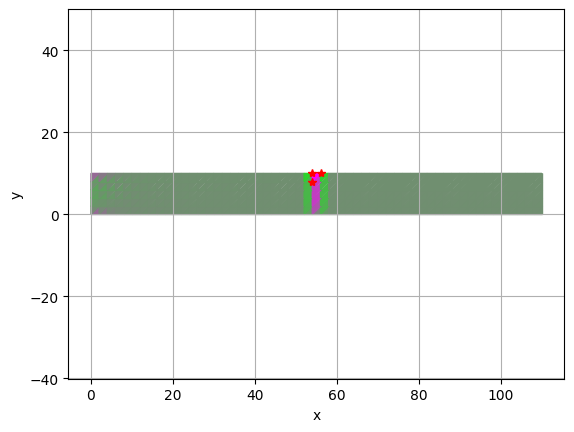

In [642]:
ln = len(NL)
le = len(EL)
lnap = np.matrix([-1,-1,-1])
max_sig = 0
max_sig_i = -1
m_s=0
m_s_i=-1
#обогащение
for i in range(len(NL)):
        for j in range(len(NLgl)):
          if abs(NLgl[j,0]-NL[i,0])<h/10000 and abs(NLgl[j,1]-NL[i,1])<h/10000:
              #print(NLgl[j,0],NL[i,0],NLgl[j,1],NL[i,1])
              #print(U[i*2],U[i*2+1])
              U[i*2] = Ufin[j*2]
              U[i*2+1]= Ufin[j*2+1]
for i in range(le):
    B = make_B(i,EL,NL,D)
    Ui = np.zeros((6))
    Ui[0] = U[EL[i,0]*2]
    Ui[1] = U[EL[i,0]*2+1]
    Ui[2] = U[EL[i,1]*2]
    Ui[3] = U[EL[i,1]*2+1]  
    Ui[4] = U[EL[i,2]*2]
    Ui[5] = U[EL[i,2]*2+1]#деформации (эпсилон)    
    Eps = B.dot(Ui)    # напряжения(сигма)
    Nap = D.dot(Eps) 
    lnap = np.append(lnap,[[Nap[0],Nap[1],Nap[2]]],axis=0)
    NapM = np.matrix([[Nap[0],Nap[2]],[Nap[2],Nap[1]]]) 
    now_sig = abs(Nap[0])
    a = NL[EL[i,0],:]
    b = NL[EL[i,1],:]
    c = NL[EL[i,2],:]
    #print(now_sig)
    e = plt.Polygon([a,b,c],color=[abs(now_sig)/227029562,1 - abs(now_sig)/227029562,abs(now_sig)/227029562])
    #e = plt.Polygon([a,b,c],color=[abs(now_sig)/4500,1 - abs(now_sig)/4500,abs(now_sig)/4500])
    #e = plt.Polygon([a,b,c],color=[abs(now_sig)/19195717270,1 - abs(now_sig)/19195717270,abs(now_sig)/19195717270])
    plt.gca().add_patch(e)
    #Sig,s = np.linalg.eig(NapM)         
    #now_sig = ma.sqrt(Nap[0]**2-Nap[0]*Nap[1]+Nap[1]**2+3*Nap[2]**2)
    if(NL[EL[i,2],0]==55 and NL[EL[i,2],1]==10-delta ):
      print(now_sig)
    if(NL[EL[i,1],0]==55 and NL[EL[i,1],1]==10-delta ):
      print( now_sig)
    if(NL[EL[i,0],0]==55 and NL[EL[i,0],1]==10-delta ):
      print(now_sig)
    if now_sig > max_sig:
        max_sig = now_sig
        #print("максимум ",max_sig)
        max_sig_i = i
    
print("sigmamax = ",max_sig)
a = NL[EL[max_sig_i,0],:]
b = NL[EL[max_sig_i,1],:]
c = NL[EL[max_sig_i,2],:]
print(a,b,c)
El = EL + np.ones((EL.shape[0],EL.shape[1]))
EL = EL.astype(int)
#x0, y0 = NLgl[ELgl[:,0]-1,0], NLgl[ELgl[:,0]-1,1]
#x1, y1 = NLgl[ELgl[:,1]-1,0], NLgl[ELgl[:,1]-1,1]
#x2, y2 = NLgl[ELgl[:,2]-1,0], NLgl[ELgl[:,2]-1,1]
#plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
#plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
#plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
plt.axis('equal')
lnap = np.delete(lnap,0,axis = 0)
print("Количество элементов ", le)
plt.grid()
#e = plt.Polygon([a,b,c],color='red')
#plt.gca().add_patch(e)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(b[0],b[1],'r*')
plt.plot(a[0],a[1],'r*')
plt.plot(c[0],c[1],'r*')  
plt.show()
plt.close()
lnap = np.delete(lnap,0,axis = 0)

# Динамика роста дефекта


Алгоритм решения задачи для фиксированной начальной геометрии:
1 построение геометрии, задание свойств материала;
2 разбиение на конечные элементы, расчет напряжений; (полный цикл – глобальная, локальная задача + итерации до «сходимости»)
3 определение напряжений (maximum principal stress = stress_K) в нижней точке дефекта;
4 расчет скорости роста дефекта на данном шаге по формуле V_k=(а+m*stress_k);
5 расчет глубины на следующем шаге по формуле S_i=S_(i-1) + V_(i-1)*t где t – временной шаг;
6 построение геометрии следующего шага – с изменившейся глубиной;
7 переход к шагу 2 в цикле, цикл работает до тех пор пока полная глубина дефекта (сфера+цилиндр) S_i на каком-то шаге не станет >= h/2.


In [ ]:
def iteration_deep(ms,now_deep):
  a = 0.1
  m = 0.0008
  Vk = a+m*ms
  Si = now_deep + t*Vk
  return Si


# Картинки

In [ ]:
def paint(cord,elem):
    x0, y0 = cord[elem[:,0]-1,0], cord[elem[:,0]-1,1]
    x1, y1 = cord[elem[:,1]-1,0], cord[elem[:,1]-1,1]
    x2, y2 = cord[elem[:,2]-1,0], cord[elem[:,2]-1,1]
    plt.plot(np.array([x0,x1]),np.array([y0,y1]),'black',linewidth=0.5);
    plt.plot(np.array([x1,x2]),np.array([y1,y2]),'black',linewidth=0.5);
    plt.plot(np.array([x2,x0]),np.array([y2,y0]),'black',linewidth=0.5);
    plt.axis('equal')
    for i in range(len(cord)):
      plt.annotate(i+1,xy = (cord[i,0]+0.02,cord[i,1]),c="red")
    count2=1
    for j in range(0,len(elem)):
        plt.annotate(count2,xy = ((cord[elem[j,0]-1,0]+cord[elem[j,1]-1,0]+cord[elem[j,2]-1,0])/3,(cord[elem[j,0]-1,1]+cord[elem[j,1]-1,1]+cord[elem[j,2]-1,1])/3),c = 'blue')
        count2 += 1
    plt.savefig('my_plot.png')
    #plt.grid()
    return 

In [ ]:
def void_mesh(d1,d2,p,m,R,element_type):
    q = np.array([[0,0],[d1,0],[0,d2],[d1,d2]])
    PD = 2
    NoN = (m+1)*(p+1)*2+(m+1)*(p-1)*2
    NoE = 4*p*m
    NPE = 4
    NL = np.zeros([NoN,PD])
    a = (q[1,0]-q[0,0])/p
    b = (q[2,1]-q[0,1])/p
    
    coor11 = np.zeros([(p+1)*(m+1),PD])
    
    for i in range(1,p+2):
        coor11[i-1,0] = q[0,0]+(i-1)*a
        coor11[i-1,1] = q[0,1]
    for i in range(1,p+2):
        coor11[m*(p+1)+i-1,0] = d1/2 + R*np.cos((5*ma.pi/4)+(i-1)*ma.pi/(2*p))
        coor11[m*(p+1)+i-1,1] = d2/2 + R*np.sin((5*ma.pi/4)+(i-1)*ma.pi/(2*p))
    for i in range(1,m):
        for j in range(1,p+2):
            dx = (coor11[m*(p+1)+j-1,0]-coor11[j-1,0])/m
            dy = (coor11[m*(p+1)+j-1,1]-coor11[j-1,1])/m
            coor11[i*(p+1)+j-1,0] = coor11[(i-1)*(p+1)+j-1,0] + dx
            coor11[i*(p+1)+j-1,1] = coor11[(i-1)*(p+1)+j-1,1] + dy
    plt.plot(coor11[:,0],coor11[:,1],"*")
    
            
    coor33 = np.zeros([(p-1)*(m+1),PD])
    for i in range(1,p):
        coor33[i-1,0] = q[0,0]
        coor33[i-1,1] = q[0,1] + i*b
    for i in range(1,p):
        coor33[m*(p-1)+i-1,0] = d1/2 + R*np.cos((5*ma.pi/4)-(i)*ma.pi/(p*2))
        coor33[m*(p-1)+i-1,1] = d2/2 + R*np.sin((5*ma.pi/4)-(i)*ma.pi/(p*2))
    for i in range(1,m):
        for j in range(1,p):
            dx = (coor33[m*(p-1)+j-1,0]-coor33[j-1,0])/m
            dy = (coor33[m*(p-1)+j-1,1]-coor33[j-1,1])/m
            coor33[i*(p-1)+j-1,0] = coor33[(i-1)*(p-1)+j-1,0] + dx
            coor33[i*(p-1)+j-1,1] = coor33[(i-1)*(p-1)+j-1,1] + dy
     
    coor44 = np.zeros([(p-1)*(m+1),PD])
    for i in range(1,p):
        coor44[i-1,0] = q[1,0]
        coor44[i-1,1] = q[1,1] + i*b
    for i in range(1,p):
        coor44[m*(p-1)+i-1,0] = d1/2 + R*np.cos((7*ma.pi/4)+(i)*ma.pi/(p*2))
        coor44[m*(p-1)+i-1,1] = d2/2 + R*np.sin((7*ma.pi/4)+(i)*ma.pi/(p*2))
    for i in range(1,m):
        for j in range(1,p):
            dx = (coor44[m*(p-1)+j-1,0]-coor44[j-1,0])/m
            dy = (coor44[m*(p-1)+j-1,1]-coor44[j-1,1])/m
            coor44[i*(p-1)+j-1,0] = coor44[(i-1)*(p-1)+j-1,0] + dx
            coor44[i*(p-1)+j-1,1] = coor44[(i-1)*(p-1)+j-1,1] + dy
     
    for i in range(1,m+2):
        NL[(i-1)*4*p:i*4*p,:] = np.vstack([coor11[(i-1)*(p+1):i*(p+1),:],coor44[(i-1)*(p-1):i*(p-1),:],np.flipud(coor22[(i-1)*(p+1):i*(p+1),:]),np.flipud(coor33[(i-1)*(p-1):i*(p-1),:])])
    

    EL = np.zeros([NoE,NPE])
    for i in range(1,m+1):
        for j in range(1,4*p+1):
            if j == 1:
                EL[(i-1)*4*p+j-1,0] = (i-1)*4*p + j 
                EL[(i-1)*4*p+j-1,1] = EL[(i-1)*4*p+j-1,0] + 1
                EL[(i-1)*4*p+j-1,3] = EL[(i-1)*4*p+j-1,0] + 4*p
                EL[(i-1)*4*p+j-1,2] = EL[(i-1)*4*p+j-1,3] + 1
            elif j == 4*p:
                EL[(i-1)*4*p+j-1,0] = i*4*p
                EL[(i-1)*4*p+j-1,1] = (i-1)*4*p + 1
                EL[(i-1)*4*p+j-1,2] = EL[(i-1)*4*p+j-1,0] + 1
                EL[(i-1)*4*p+j-1,3] = EL[(i-1)*4*p+j-1,0] + 4*p 
            else:
                EL[(i-1)*4*p+j-1,0] = EL[(i-1)*4*p+j-2,1]
                EL[(i-1)*4*p+j-1,3] = EL[(i-1)*4*p+j-2,2]
                EL[(i-1)*4*p+j-1,2] = EL[(i-1)*4*p+j-1,3] + 1
                EL[(i-1)*4*p+j-1,1] = EL[(i-1)*4*p+j-1,0] + 1
    if element_type == 'D2TR3N':
        NPEn = 3
        NoEn = 2*NoE
        ELn = np.zeros([NoEn,NPE])
        for i in range(1,NoE+1):
            ELn[2*(i-1),0] = EL[i-1,0] 
            ELn[2*(i-1),1] = EL[i-1,1] 
            ELn[2*(i-1),2] = EL[i-1,2] 
            ELn[2*(i-1)+1,0] = EL[i-1,0] 
            ELn[2*(i-1)+1,1] = EL[i-1,2] 
            ELn[2*(i-1)+1,2] = EL[i-1,3] 
        EL = ELn 
    EL = EL.astype(int)
    return NL,EL

Глобальная сетка, p =  4 , m =  10


TypeError: ignored

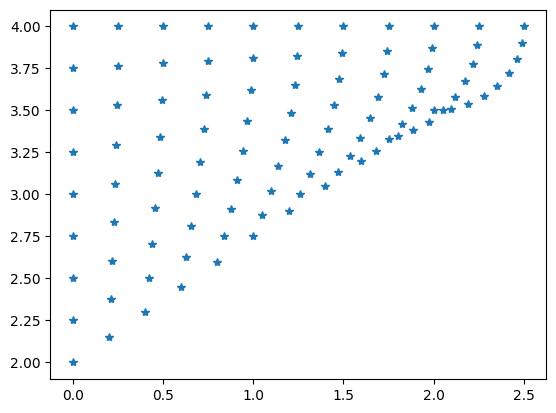

In [575]:
element_type = 'D2TR3N'
print("Глобальная сетка, p = ",p,", m = ",m)
d1=2
d2=4
p=4
p1 = 8
m=10
R=0.5
g = 0
gh = 0
NL, EL = void_mesh(d1,d2,p,m,R,element_type)
ss = []

